### Analysing Individual Analysts

This notebook looks at how each individual analyst performed in the experiment

In [1]:
import os
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import itertools

In [3]:
from facct22.utils import get_db_con

from facct22.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    ttests_operational_metrics
)

In [4]:
cred_file = '../../conf/credentials.yaml'
engine = get_db_con(cred_file)

In [6]:
all_decisions = get_all_decisions(engine, schemas, users, groups)
suspicious_msk = all_decisions['decision'] == 'suspicious'

In [7]:
msk = all_decisions['trx_amnt'] > 2000
all_decisions.loc[msk, 'trx_amnt'] = 2000

In [9]:
params={
    'fn': -1, 
    'p_loss_trx': 0.4, # prob of losing this transaction
    'cust_worth': 0, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 0.1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

In [39]:
def plot_metric_by_user(metric_df, plot_order, title=None, confidence=0.9):
    users = sorted(metric_df['user_name'].unique())
    groups = list(metric_df['group'].unique())
    
    fig, ax = plt.subplots(dpi=200)
#     fig, ax = plt.subplots()
    x = np.arange(len(users))
    width = 0.09  # the width of the bars
    h = len(groups)
    positions = list()

    pos = -0.30
    for i, g in enumerate(plot_order):
        msk = metric_df['group'] == g
        df = metric_df[msk].sort_values('user_name')
        means = df['mean'].tolist()
        n = df['n'].iloc[0]
        ses = [x * stats.t.ppf((1 + confidence) / 2., n-1)  for x in df['se'].tolist()]
        rects = ax.bar(
            x + pos, 
            means, 
            width, 
            label=g, 
            align='center', 
            yerr=ses,  
            capsize=4,
            alpha=0.7,
            color=colors[i]
        )
        pos = pos + width + 0.01
        positions.append(pos)

    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xticks(x)
    ax.set_xticklabels(users)
    if title:
        ax.set_title(title)
    sns.despine()
    
    return fig, ax

#### dps

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7940d4e3c8>)

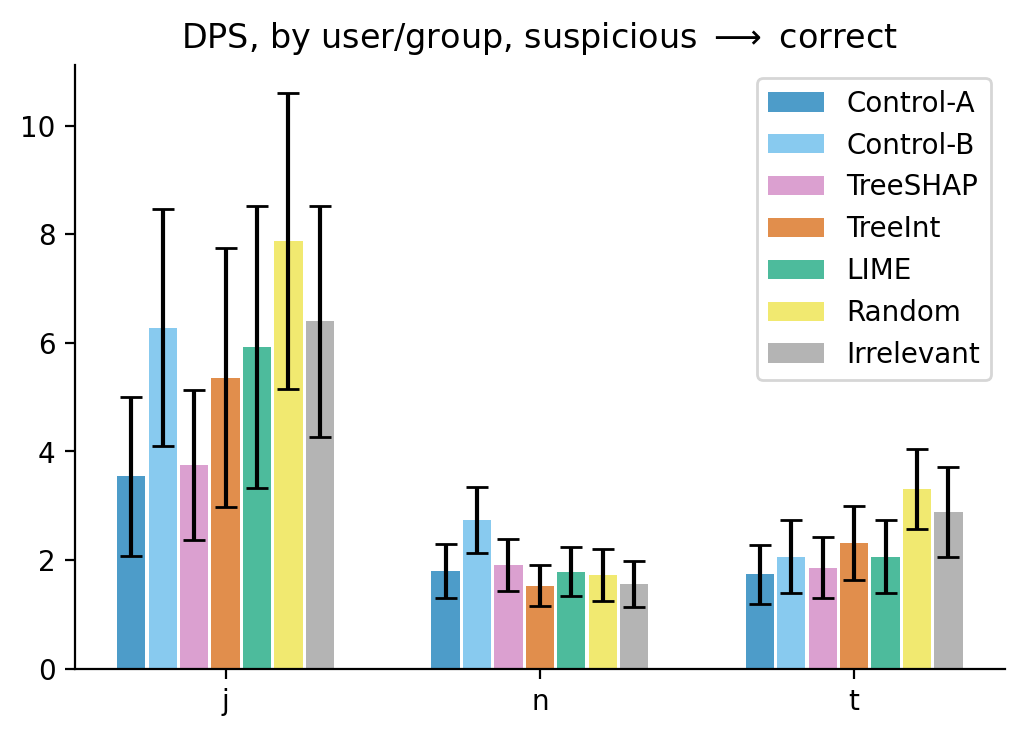

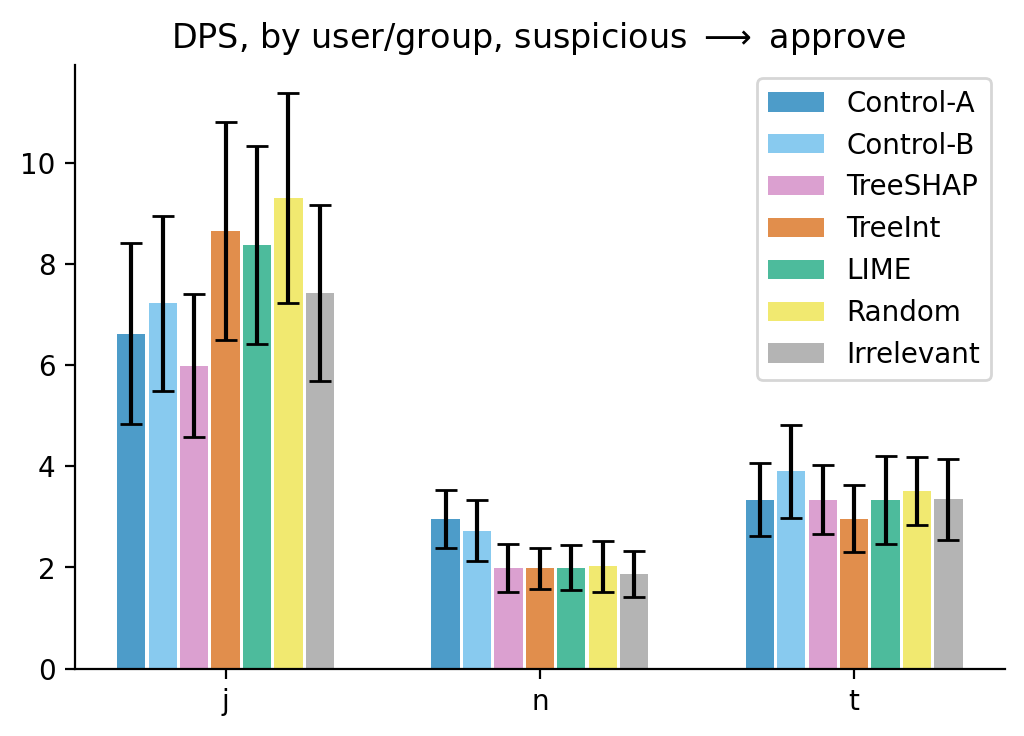

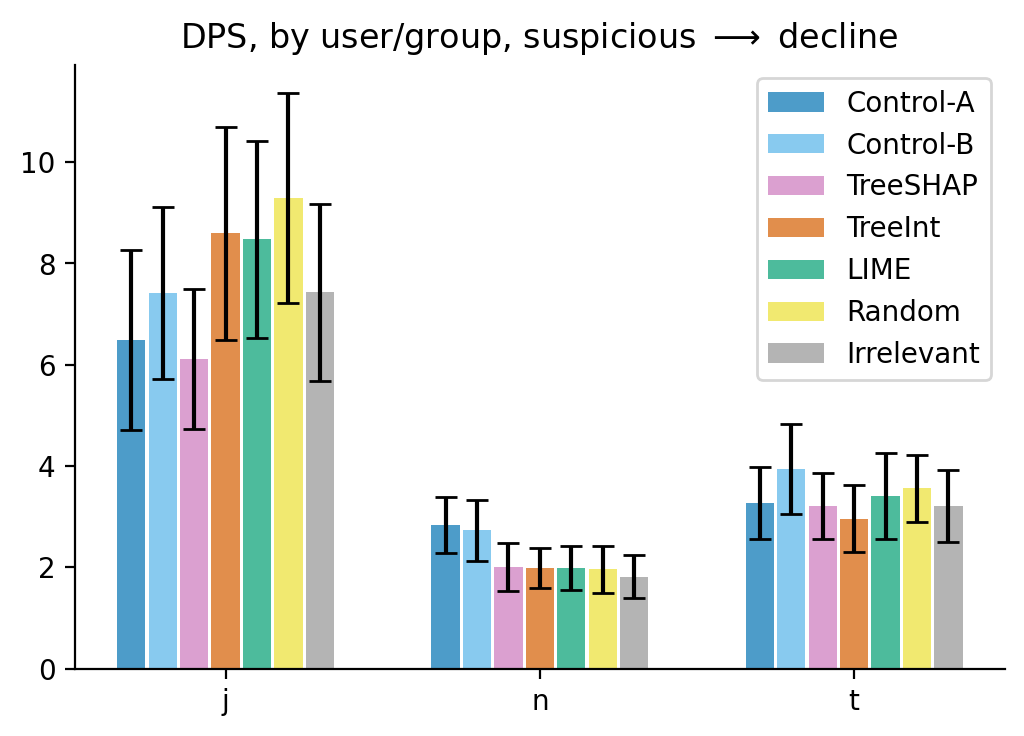

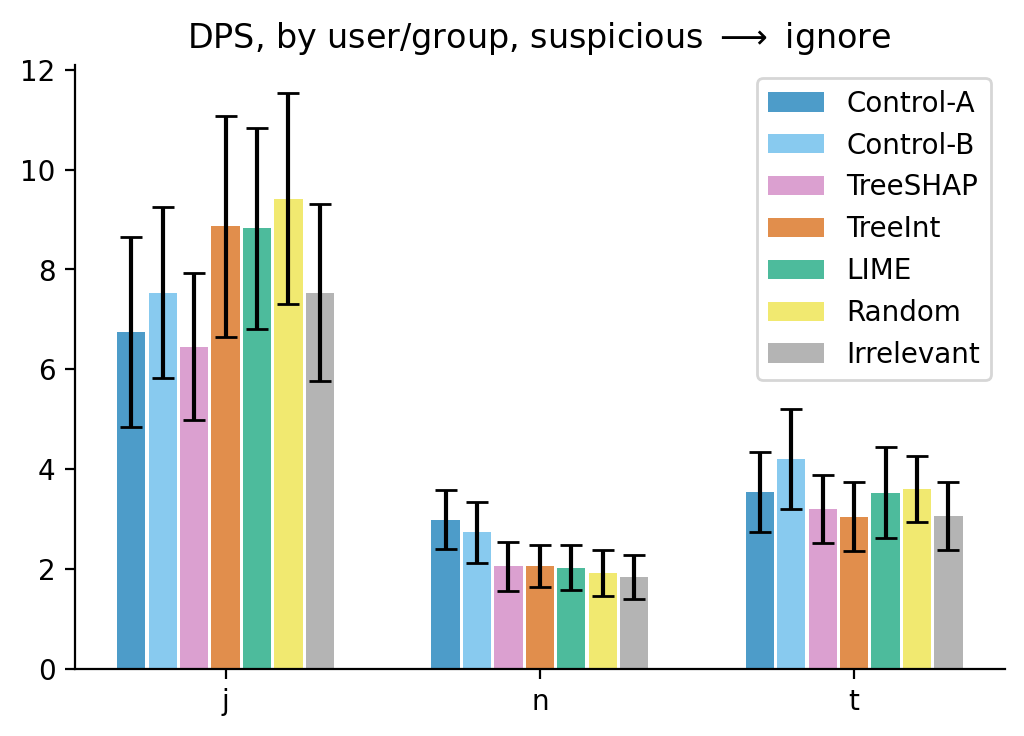

In [40]:
df = dps(all_decisions, params, 'correct', ['group', 'user_name'])
plot_metric_by_user(df, group_order, 'DPS, by user/group, suspicious $\longrightarrow$ correct ')

df = dps(all_decisions, params, 'approve', ['group', 'user_name'])
plot_metric_by_user(df, group_order, 'DPS, by user/group, suspicious $\longrightarrow$ approve ')

df = dps(all_decisions, params, 'decline', ['group', 'user_name'])
plot_metric_by_user(df, group_order, 'DPS, by user/group, suspicious $\longrightarrow$ decline ')

df = dps(all_decisions[~suspicious_msk], params, 'correct', ['group', 'user_name'])
plot_metric_by_user(df, group_order, 'DPS, by user/group, suspicious $\longrightarrow$ ignore ')


**Notes**

- All explainers seem to performing similarly, esp for N and T

#### DT

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79405ae5c0>)

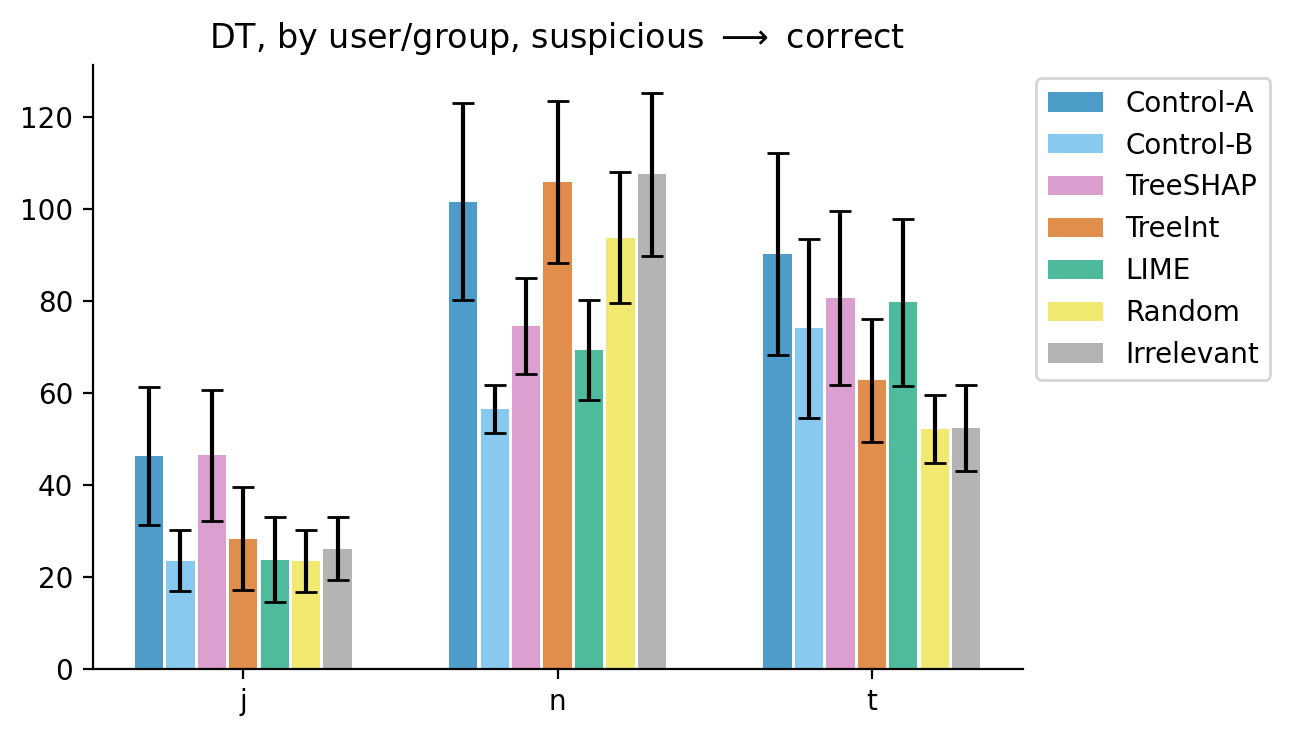

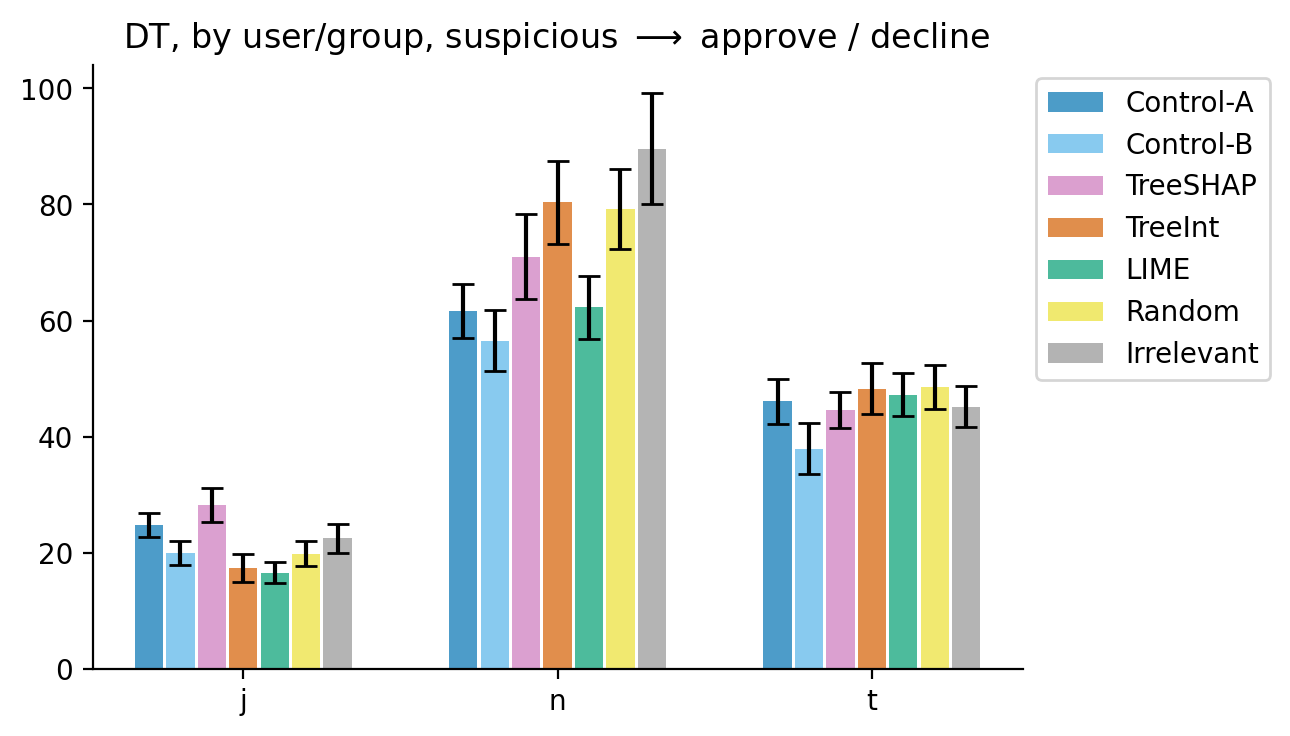

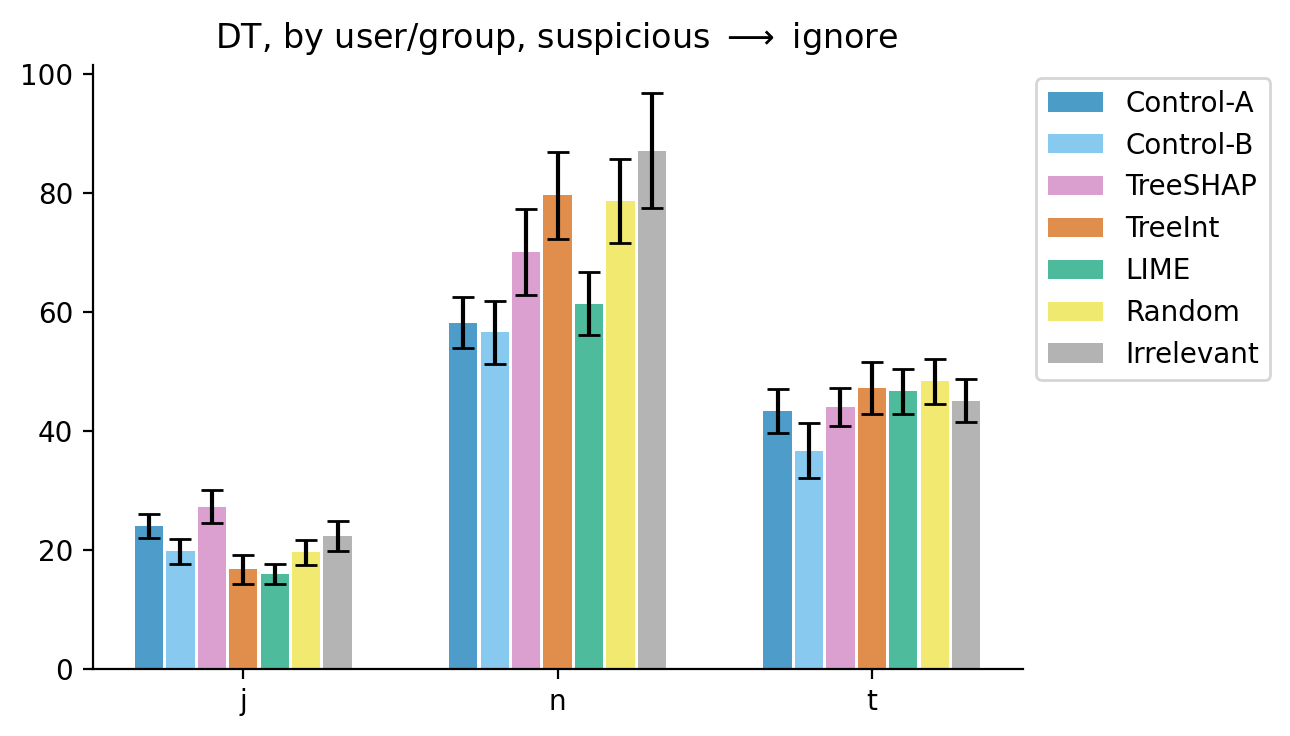

In [46]:
df = dt(all_decisions, params, 'correct', ['group', 'user_name'])
plot_metric_by_user(df, group_order, 'DT, by user/group, suspicious $\longrightarrow$ correct ')

df = dt(all_decisions, params, 'approve', ['group', 'user_name'])
plot_metric_by_user(df, group_order, 'DT, by user/group, suspicious $\longrightarrow$ approve / decline ')

# df = dt(all_decisions, params, 'decline', ['group', 'user_name'])
# plot_metric_by_user(df, group_order, 'DPS, by user/group, suspicious $\longrightarrow$ decline ')

df = dt(all_decisions[~suspicious_msk], params, 'correct', ['group', 'user_name'])
plot_metric_by_user(df, group_order, 'DT, by user/group, suspicious $\longrightarrow$ ignore ')

**Notes**

- Ctrl B is the best for everyone
- Intrestingly, the bad/random explainers are performing similarly to other explainers except for SHAP, which seems to be worst of the explainers for J & T (but SHAP was first)

#### PDR

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79409f1c18>)

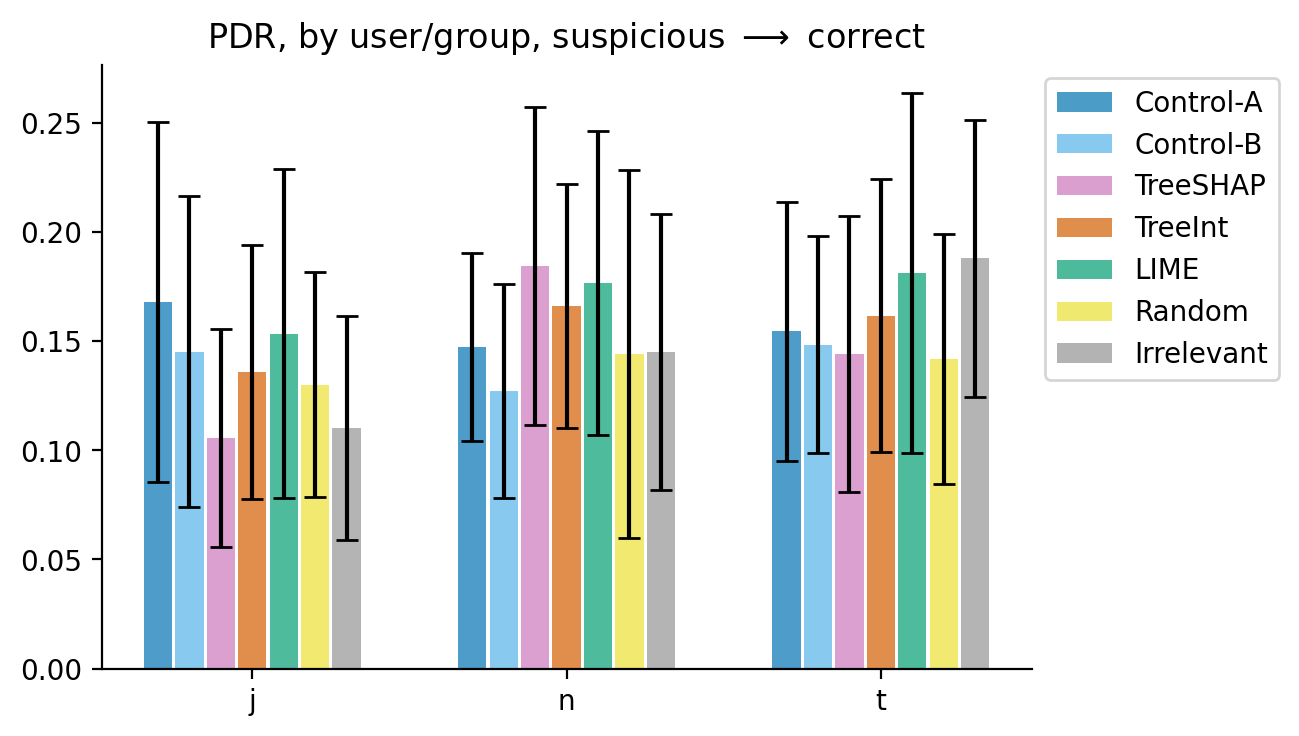

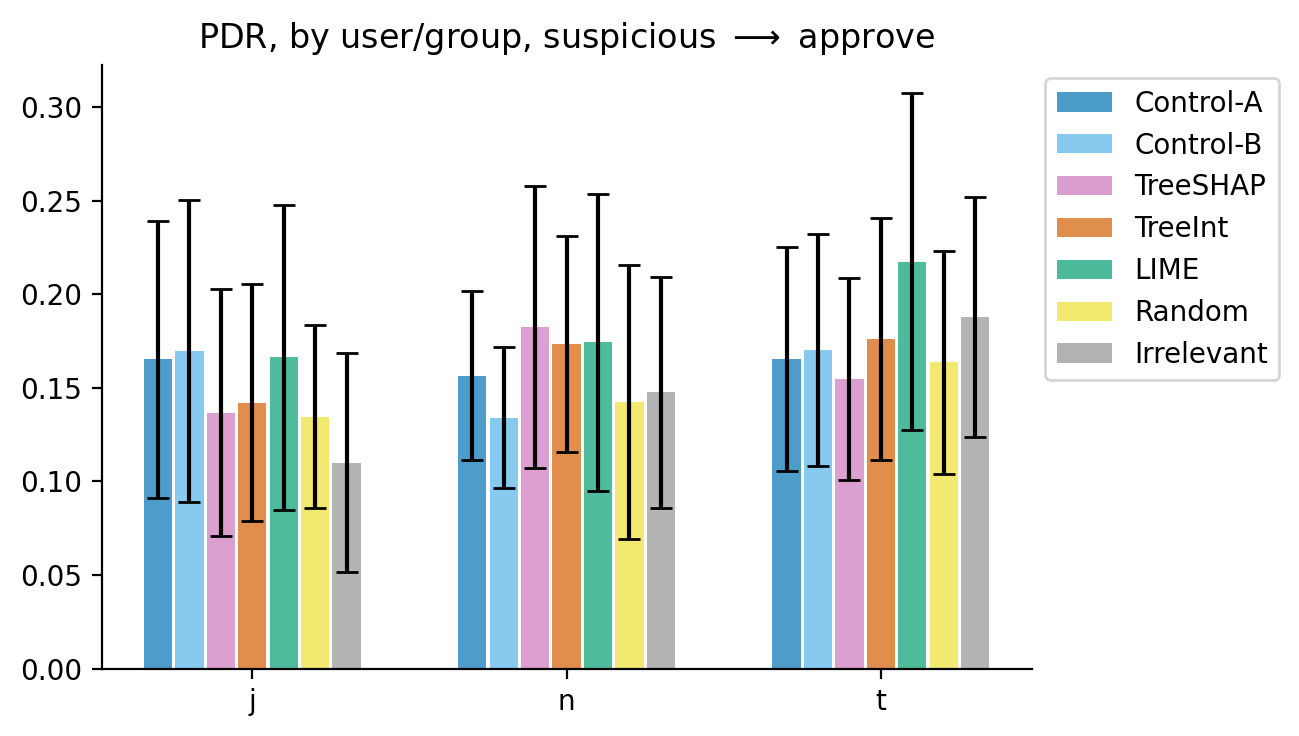

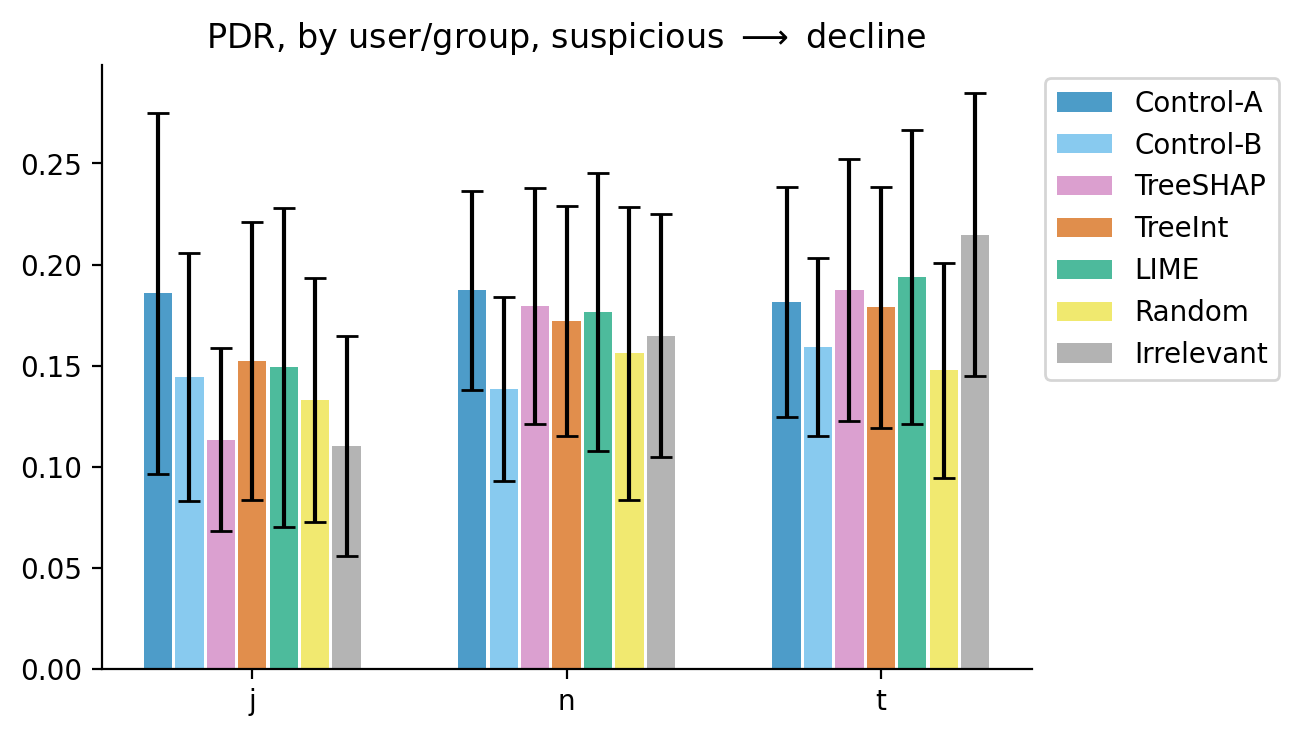

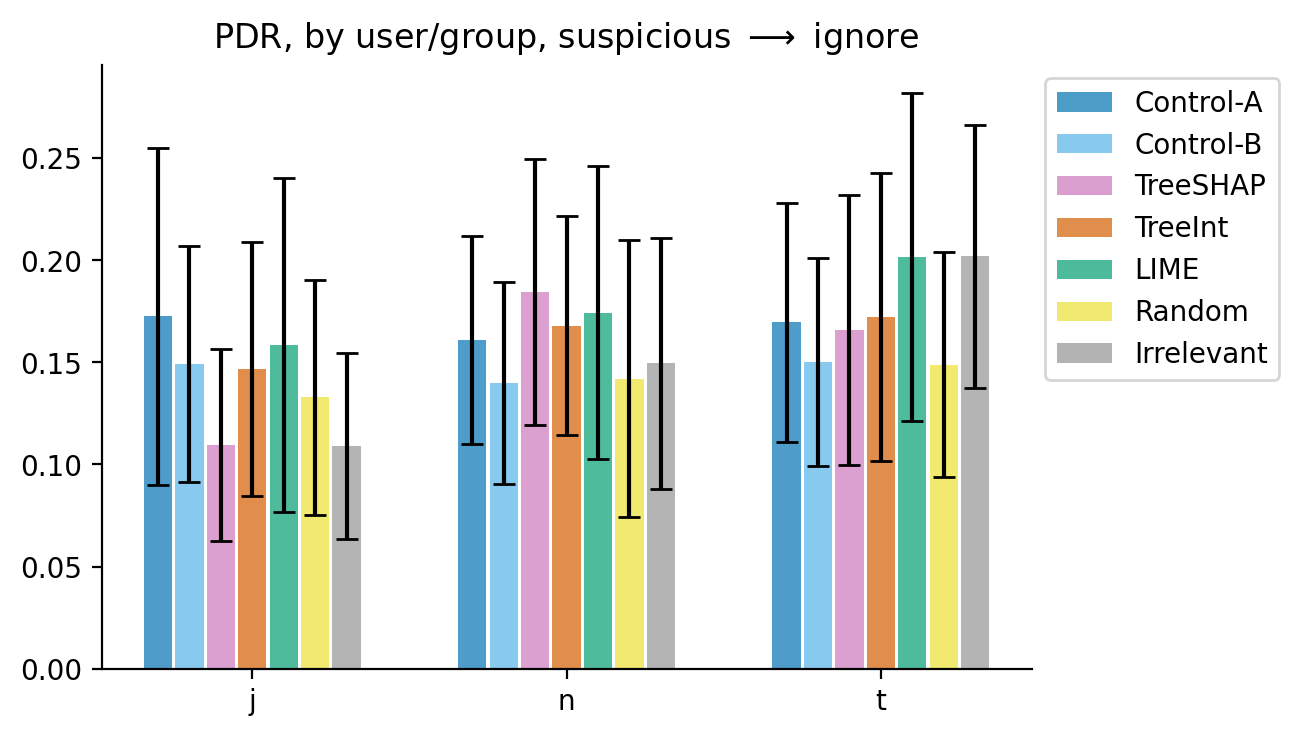

In [47]:
df = pdr(all_decisions, params, 'correct', ['group', 'user_name'], n_samples=160, n_iterations=100)
plot_metric_by_user(df, group_order, 'PDR, by user/group, suspicious $\longrightarrow$ correct ')

df = pdr(all_decisions, params, 'approve', ['group', 'user_name'], n_samples=160, n_iterations=100)
plot_metric_by_user(df, group_order, 'PDR, by user/group, suspicious $\longrightarrow$ approve')

df = pdr(all_decisions, params, 'decline', ['group', 'user_name'], n_samples=160, n_iterations=100)
plot_metric_by_user(df, group_order, 'PDR, by user/group, suspicious $\longrightarrow$ decline ')

df = pdr(all_decisions[~suspicious_msk], params, 'correct', ['group', 'user_name'], n_samples=160, n_iterations=100)
plot_metric_by_user(df, group_order, 'PDR, by user/group, suspicious $\longrightarrow$ ignore ')

### Breaking it down by decision times

##### Mean time for each decision type

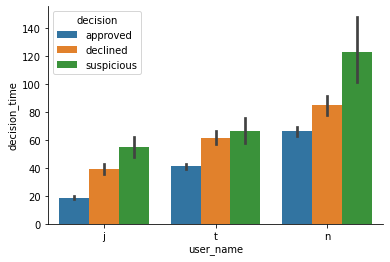

In [50]:
sns.barplot(
    data=all_decisions,
    x='user_name',
    y='decision_time',
    hue='decision',
    order=['j', 't', 'n']
)
sns.despine()

Approvals seems to be easier decisions. Understandaby, the analysts deliberate more with the suspicious ones. N spending 2mins on average 

##### Mean type for each decision type by each group 

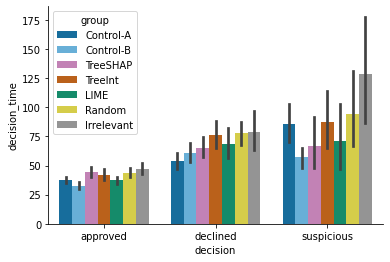

In [54]:
sns.barplot(
    data=all_decisions,
    x='decision',
    y='decision_time',
    hue='group',
    hue_order=group_order,
    palette=colors
)
sns.despine()

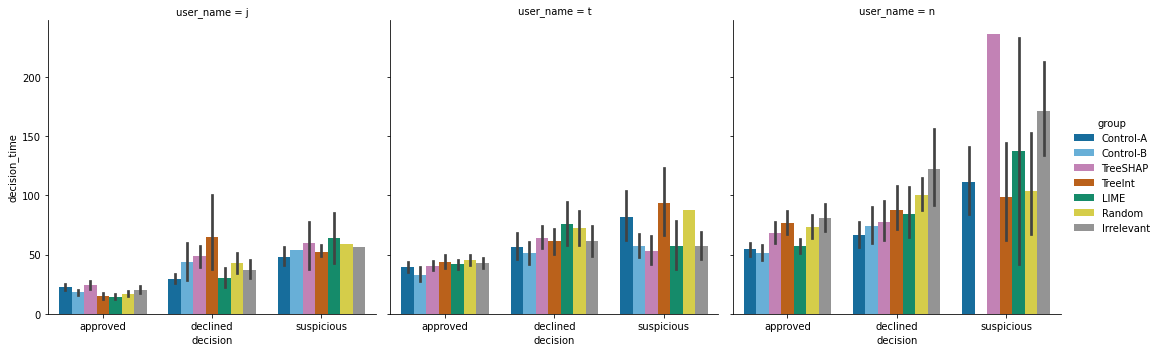

In [57]:
g = sns.catplot(
    x="decision", 
    y="decision_time",
    hue="group", 
    col="user_name",
    data=all_decisions, 
    kind="bar",
    col_order=['j', 't', 'n'],
    palette=colors,
    hue_order=group_order
)

#### Decision Percentages 

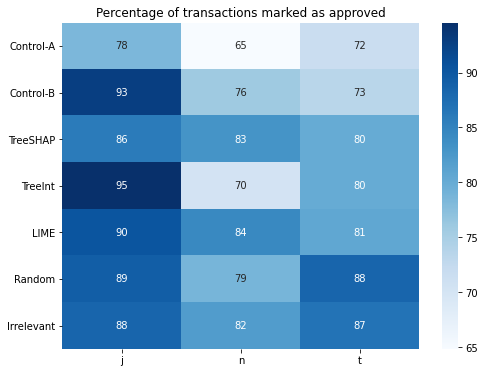

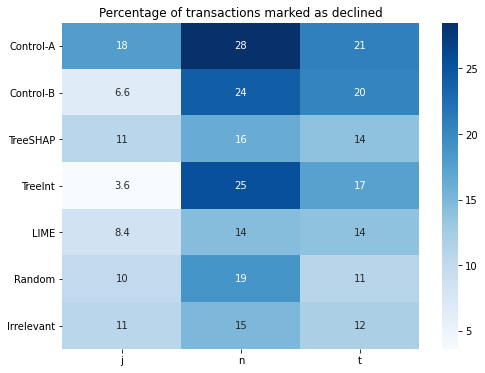

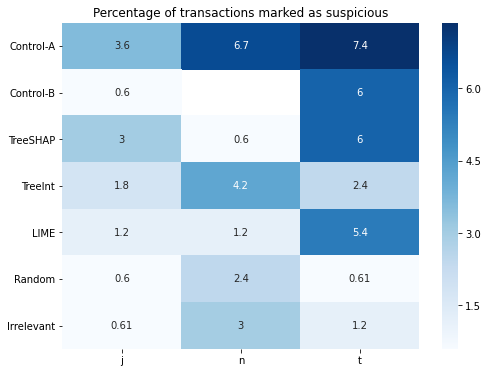

In [67]:
dec_types = all_decisions['decision'].unique()
grb_obj_arm  = all_decisions.groupby(['group'])
dfs = list()
for d in dec_types:
    msk = all_decisions['decision'] == d
        
    df = all_decisions[msk]
    grb_obj_dec  = df.groupby(['group', 'user_name'])
    grp_obj_all = all_decisions.groupby(['group', 'user_name'])
    
    dec_rate = (grb_obj_dec.count()['xplz_id'] / grp_obj_all.count()['xplz_id']) * 100
    dec_rate.name = 'decision_pct'
    dec_rate = dec_rate.reset_index() 
    dec_rate['decision'] = d
    
    dfs.append(dec_rate)
    
    pt = pd.pivot_table(dec_rate, values='decision_pct', index='group', columns='user_name')
    pt = pt.reindex(group_order)
    
    fix, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pt, cmap="Blues", annot=True)
    ax.set_title(f'Percentage of transactions marked as {d}')
    ax.set_xlabel('')
    ax.set_ylabel('')

#### Decison Percentages across arms

In [69]:
dec_pct = pd.concat(dfs)

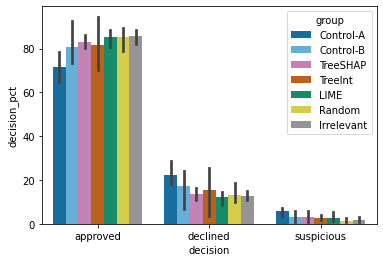

In [71]:
sns.barplot(
    data=dec_pct,
    x='decision',
    y='decision_pct',
    hue='group',
    hue_order=group_order,
    palette=colors
)

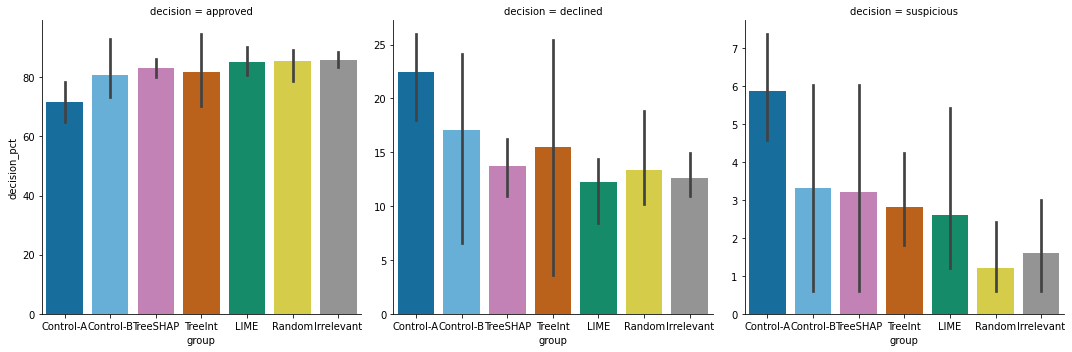

In [75]:
g = sns.catplot(
    x="group", 
    y="decision_pct",
    col="decision",
    data=dec_pct, 
    kind="bar",
    palette=colors,
    sharey=False,
    order=group_order
)

- Suspicious rate is dropping with model score --> Makes the analysts more confident/decisive?
- Approval rate increases with the model score, and the declined rate & suspcious rate drops --> Trxs that would have been suspicious/declined ones are getting approved with the help of the model score? (intersting CF?)
- Suspicious rate drops with random/bad (by ~1.5%) --> declined rate going up?
- Explainers don't seem to add any incremental impact